### Austin Collins
### Feb 21, 2023

# Business Understanding

A regional bank in Texas recently started offering term deposits as a way for their customers to invest their money. Term deposits are time-restricted investments that offer some fixed rate of return over a pre-defined measure of time, ranging anywhere from three months to several years. These kinds of investments are typically attractice to those who are more risk-averse, concerned about movement in the stock market, or want a fixed amount of money coming in every month. Customers at the bank can easily transfer funds from their current accounts to these term deposits, and while there are some limitations on withdrawing money from these term deposit accounts, they offer a higher interest rate than normal checking or savings accounts, so there is an attractive tradeoff for those with extra capital.

This regional bank recently underwent a sales/marketing campaign to encourage current customers to also sign up for term deposits. This was done by contacting customers over the phone to gauge their interest and discuss their options.

Our goal is to take the data from their sales campaign and predict whether or not a customer signed up for term deposits. From there, we can determine feature importances from our model and gauge how best to optimize future sales efforts for term deposits that are highly lucrative for the bank.

As always, we'll start by import the libraries we'll use for our analysis and model building.

In [51]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('bank-full.csv')

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Right away we can see that we have no missing values, which makes our lives much easier. We also have lots of categorical information, which will lend itself nicely to classifiers such as Decision Trees and Random Forests.

Below, we'll explore more about some of the information 

In [4]:
df['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [5]:
df['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Marital status is a category, so we'll leave that alone for now and peform some one hot encoding later.

Education, though, is a sliding scale where more education could be represented by a higher number, so we can replace that with number values for modeling purposes.

In [6]:
df['default'].value_counts()

no     44396
yes      815
Name: default, dtype: int64

Default is a binary classifier, so we can quickly make that a binary variable for modeling.

In [7]:
df['default'] = df['default'].replace({'no':0, 'yes':1}).astype(float)

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0.0,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,0.0,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,0.0,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,0.0,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,0.0,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0.0,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,0.0,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,0.0,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,0.0,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


It appears the same binary nature rings true for housing and loan columns, which identify whether or not a customer has that type of loan to their name.

In [8]:
df['housing'] = df['housing'].replace({'no':0, 'yes':1}).astype(float)
df['loan'] = df['loan'].replace({'no':0, 'yes':1}).astype(float)
df['balance'] = df['balance'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45211 non-null  int64  
 1   job        45211 non-null  object 
 2   marital    45211 non-null  object 
 3   education  45211 non-null  object 
 4   default    45211 non-null  float64
 5   balance    45211 non-null  float64
 6   housing    45211 non-null  float64
 7   loan       45211 non-null  float64
 8   contact    45211 non-null  object 
 9   day        45211 non-null  int64  
 10  month      45211 non-null  object 
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  pdays      45211 non-null  int64  
 14  previous   45211 non-null  int64  
 15  poutcome   45211 non-null  object 
 16  y          45211 non-null  object 
dtypes: float64(4), int64(6), object(7)
memory usage: 5.9+ MB


In [9]:
df['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

For the "previous marketing outcome" column, we're going to make unknown and other the same value, since the fact they aren't a win or loss puts them in the same ambiguous category we can account for later. 

In [10]:
#replace poutcome value 'unknown' with 'other'
df['poutcome'] = df['poutcome'].replace({'unknown':'other'})
df['day'] = df['day'].astype(float)
df['duration'] = df['duration'].astype(float)
df['campaign'] = df['campaign'].astype(float)
df['pdays'] = df['pdays'].astype(float)
df['previous'] = df['previous'].astype(float)
df['age'] = df['age'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45211 non-null  float64
 1   job        45211 non-null  object 
 2   marital    45211 non-null  object 
 3   education  45211 non-null  object 
 4   default    45211 non-null  float64
 5   balance    45211 non-null  float64
 6   housing    45211 non-null  float64
 7   loan       45211 non-null  float64
 8   contact    45211 non-null  object 
 9   day        45211 non-null  float64
 10  month      45211 non-null  object 
 11  duration   45211 non-null  float64
 12  campaign   45211 non-null  float64
 13  pdays      45211 non-null  float64
 14  previous   45211 non-null  float64
 15  poutcome   45211 non-null  object 
 16  y          45211 non-null  object 
dtypes: float64(10), object(7)
memory usage: 5.9+ MB


With our added data file in hand, we can replace column names to make analysis and explanations easier down the road. The .txt file that accompanies the .csv fata file explains each column name in more detail.

In [11]:
#rename loan column to be personal loan
df = df.rename(columns={'loan':'personal loan'})

#rename housing column to be housing loan
df = df.rename(columns={'housing':'housing loan'})

#rename default column to be credit in default
df = df.rename(columns={'default':'credit in default'})

#rename contact column to be contact type
df = df.rename(columns={'contact':'contact type'})

#rename marital column to be marital status
df = df.rename(columns={'marital':'marital status'})

#rename education column to be education level
df = df.rename(columns={'education':'education level'})

#rename balance column to be account balance
df = df.rename(columns={'balance':'account balance'})

#rename campaign column to be number of contacts
df = df.rename(columns={'campaign':'number of contacts'})

#rename pdays column to be days since last contact
df = df.rename(columns={'pdays':'days since last contact'})

#rename previous column to be number of contacts before current campaign
df = df.rename(columns={'previous':'number of contacts before current campaign'})

#rename poutcome column to be outcome of previous marketing campaign
df = df.rename(columns={'poutcome':'outcome of previous marketing campaign'})

#rename duration column to be last contact duration in seconds
df = df.rename(columns={'duration':'last contact duration in seconds'})

#rename day column to be last contact day
df = df.rename(columns={'day':'last contact day'})

#rename month column to be last contact month
df = df.rename(columns={'month':'last contact month'})

#rename y column to be subscribed to term deposit
df = df.rename(columns={'y':'subscribed to term deposit'})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         45211 non-null  float64
 1   job                                         45211 non-null  object 
 2   marital status                              45211 non-null  object 
 3   education level                             45211 non-null  object 
 4   credit in default                           45211 non-null  float64
 5   account balance                             45211 non-null  float64
 6   housing loan                                45211 non-null  float64
 7   personal loan                               45211 non-null  float64
 8   contact type                                45211 non-null  object 
 9   last contact day                            45211 non-null  float64
 10  last conta

Now to prepare for modeling, we need to make our target variable a number value, for sake of ease.

Right before we do that, let's check correlation values to see if there's any significant relationships between variables that might affect our model in some way.

<AxesSubplot: >

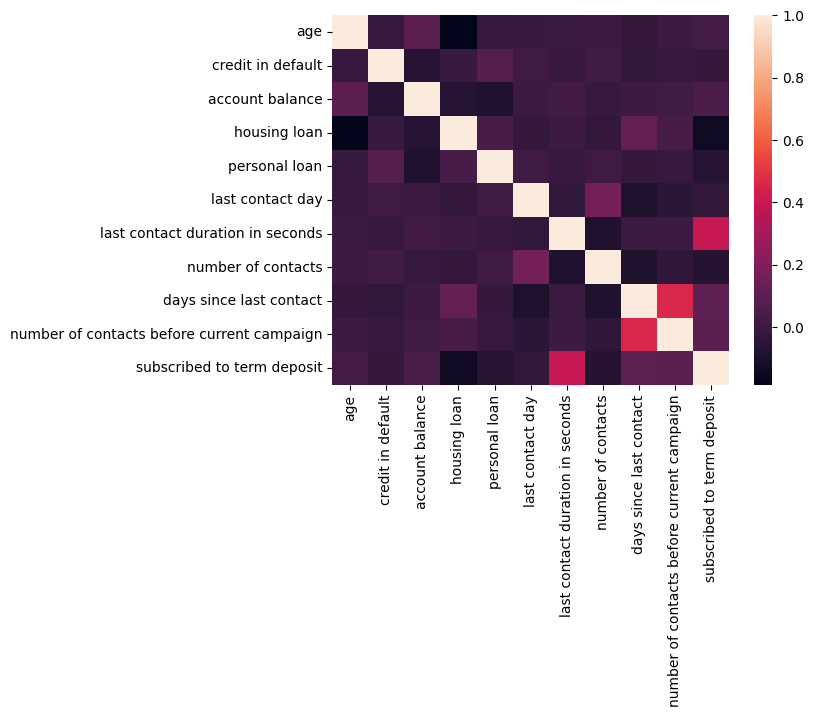

In [52]:
sns.heatmap(df_post_model.corr())

In [13]:
#transform target variable to be float
df['subscribed to term deposit'] = df['subscribed to term deposit'].replace({'no':0, 'yes':1}).astype(float)

After we perform our modeling, we will want to revisit this dataset and dig through some values to help with our recommendations after we find the most important features. So, we'll make a copy for just that purpose.

In [14]:
df_post_model = df.copy()

# Pre-Processing

As with any categorical variables, we will be One Hot Encoding columns to prepare for modeling. OHE allows a column like marital status, which has three possible text entries, to be split into three columns with a binary value of 0 or 1 indicating which marital status a person has.

This process will be applied across all possible object columns.

In [15]:
#one hot encode categorical variables
df = pd.get_dummies(df, columns=['job', 'marital status', 'education level','contact type', 'last contact month', 'outcome of previous marketing campaign'])

In [16]:
df

,age,credit in default,account balance,housing loan,personal loan,last contact day,last contact duration in seconds,number of contacts,days since last contact,number of contacts before current campaign,...,last contact month_jul,last contact month_jun,last contact month_mar,last contact month_may,last contact month_nov,last contact month_oct,last contact month_sep,outcome of previous marketing campaign_failure,outcome of previous marketing campaign_other,outcome of previous marketing campaign_success
0,58.0,0.0,2143.0,1.0,0.0,5.0,261.0,1.0,-1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,44.0,0.0,29.0,1.0,0.0,5.0,151.0,1.0,-1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,33.0,0.0,2.0,1.0,1.0,5.0,76.0,1.0,-1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,47.0,0.0,1506.0,1.0,0.0,5.0,92.0,1.0,-1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,33.0,0.0,1.0,0.0,0.0,5.0,198.0,1.0,-1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,0.0,825.0,0.0,0.0,17.0,977.0,3.0,-1.0,0.0,...,0,0,0,0,1,0,0,0,1,0
45207,71.0,0.0,1729.0,0.0,0.0,17.0,456.0,2.0,-1.0,0.0,...,0,0,0,0,1,0,0,0,1,0
45208,72.0,0.0,5715.0,0.0,0.0,17.0,1127.0,5.0,184.0,3.0,...,0,0,0,0,1,0,0,0,0,1
45209,57.0,0.0,668.0,0.0,0.0,17.0,508.0,4.0,-1.0,0.0,...,0,0,0,0,1,0,0,0,1,0


Now, we will apply a MinMaxScaler. This scaler takes the maximum and minimum values of each column and turns them into 1 and 0 respectively. Every other value in the column will be turned into a fraction (represented by a decimal) of the max value. For instance, if the max value of a column was 10, that 10 is now 1, and any row with a value 4 is now 0.4. This places all variable on the same unit scale while preserving the binary nature of one hot encoded variables. When all variables are on the same scale, feature importance can be determined much more reliably. 

In [17]:
#add minmax scaler to normalize data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [18]:
#display all columns
pd.set_option('display.max_columns', None)
df

,age,credit in default,account balance,housing loan,personal loan,last contact day,last contact duration in seconds,number of contacts,days since last contact,number of contacts before current campaign,subscribed to term deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital status_divorced,marital status_married,marital status_single,education level_primary,education level_secondary,education level_tertiary,education level_unknown,contact type_cellular,contact type_telephone,contact type_unknown,last contact month_apr,last contact month_aug,last contact month_dec,last contact month_feb,last contact month_jan,last contact month_jul,last contact month_jun,last contact month_mar,last contact month_may,last contact month_nov,last contact month_oct,last contact month_sep,outcome of previous marketing campaign_failure,outcome of previous marketing campaign_other,outcome of previous marketing campaign_success
0,0.519481,0.0,0.092259,1.0,0.0,0.133333,0.053070,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.337662,0.0,0.073067,1.0,0.0,0.133333,0.030704,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.194805,0.0,0.072822,1.0,1.0,0.133333,0.015453,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.376623,0.0,0.086476,1.0,0.0,0.133333,0.018707,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.194805,0.0,0.072812,0.0,0.0,0.133333,0.040260,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.0,0.080293,0.0,0.0,0.533333,0.198658,0.032258,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45207,0.688312,0.0,0.088501,0.0,0.0,0.533333,0.092721,0.016129,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45208,0.701299,0.0,0.124689,0.0,0.0,0.533333,0.229158,0.064516,0.212156,0.010909,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45209,0.506494,0.0,0.078868,0.0,0.0,0.533333,0.103294,0.048387,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Modeling

As a plan of action, we will be using a single decision tree model to start, then a random forest as a form of aggregation, then an ADABoost model to see if we can further improve performance.

Our target variable is whether or not the customer subscribed to a term deposit account. 

In [19]:
#tree classifier
X = df.drop('subscribed to term deposit', axis=1)
y = df['subscribed to term deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(class_weight='balanced',random_state=42) 
#balanced to treat outcomes equally even though only 11% of customers have subscribed
tree.fit(X_train, y_train)

tree_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')

tree_scores

array([0.87074924, 0.87614045, 0.87904341, 0.87875017, 0.87570856])

In [20]:
tree_scores.mean()

0.8760783649082338

Our first tree predicted 87.5% of value correctly! Now we will see if we can tune our tree to be even more accurate.

To tune the hyperpeamaters of the decision tree, we can use the GridSearchCV method. This allows us to create a list of dictionaries where we can input various tuning options and try out all of the combinations that can be made therein.

To explain GridSearchCV, we can make an analogy with sandwiches. If you were trying to find the tastiest possible sandwich, you could do so by trying all the possible combinations of a type of meat, a type of cheese, and one type of condiment. Once you make all possible combinations, you can rank them by tastiness and then pick the one that was determined to be the tastiest. This is essentially how GridSearch works. You provide a lsit of all possible values your hyperperamters can have, and GridSearch tries all possible combinations to find the best one according to which measurement you want to use (accuracy in this case).

Our hyperparameters of choice will be the split decision criteria, max depth, and max features.

Max depth is how many layers deep our decision tree can be. If you had a tree that started with all possible data, and then split once into two groups, that would be a max depth of 2.

Max features determines how many features are used to make decisions at each split. So our data set has 17 possible features to split upon. At each splits, the model will pick a random selection of 4 features in order to bucket customers as churned or not churned (the square root of 17 is 4.12). That does not mean the model will only use 4 features overall, it just means that it will use 4 features at each of the six splits that our tree has.

Our model will use the "best" splitter when determining what threshold the data in a given feature will have to cross to be considered churned. So, our model will determine which threshold it thinks is best and use that, rather than trying different thresholds at random. So if the model thinks that having an account length of 20 is the best split, anything above 20 would be classified one way, and anything under 20 would be classified the other way.

Now we can build a decision tree with these hyperparameters and see if it performed any better.

In [21]:
tree_hyperperams = {
    "splitter" : ['best','random'],
    "max_depth" : [3,4,5,6,7],
    "max_features" : ['sqrt','log2']  
}

tree_grid = GridSearchCV(estimator = tree,
                    param_grid = tree_hyperperams,
                    scoring = 'accuracy',
                    cv=5
                   )

In [22]:
tree_grid.fit(X_train, y_train)

tree_grid.best_params_

{'max_depth': 3, 'max_features': 'log2', 'splitter': 'best'}

So our ideal tree, in theory, will have 3 splits, include the log of total variables, and choose the best value rather than splitting at random.

However, when implementing models, it was found that only changing the splitter to random proved to have the best results.

In [23]:
tree_tuned = DecisionTreeClassifier(class_weight='balanced',random_state=42, splitter='random')

tree_tuned.fit(X_train, y_train)

tree_tuned_scores = cross_val_score(tree_tuned, X_train, y_train, cv=5, scoring='accuracy')

tree_tuned_scores

array([0.88263754, 0.8771081 , 0.87793752, 0.8768146 , 0.87695285])

In [24]:
tree_tuned_scores.mean()

0.8782901235127101

Now that we see some improved performance over the baseline, let's run it on a test set and gauge its prediction power.

In [25]:
tree_y_pred = tree_tuned.predict(X_test)

0.8776954550481035

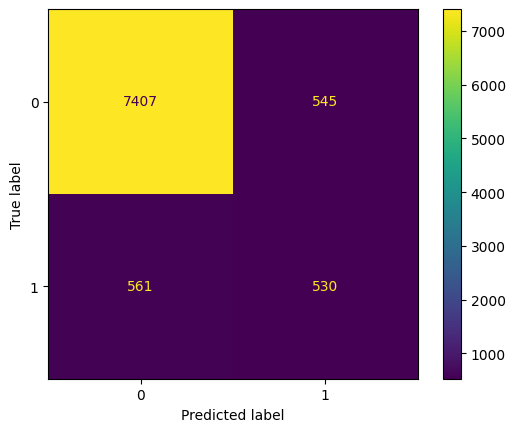

In [26]:
cm = confusion_matrix(y_test, tree_y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


tree_accuracy = accuracy_score(y_test, tree_y_pred)

tree_accuracy

In [53]:
print(classification_report(y_test, tree_y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      7952
         1.0       0.49      0.49      0.49      1091

    accuracy                           0.88      9043
   macro avg       0.71      0.71      0.71      9043
weighted avg       0.88      0.88      0.88      9043



The confusion matrix above shows us the comparisons between the actual data and our model's predictions, where 0 is "not churned" and 1 is ""churned." On the bottom we have our predictions, and actual results are on the left. The squares then represent the intersections between those labels.

Top left is true negatives, where the model predicted they did not churn, and they in fact did not. Top right is false positives, where the model though they would churn, but they did not. Bottom left is false negatives, where the model though they did not churn when they in fact had. Bottom right is true positives, where the model thinks they did churn, and they in fact did. At 87% accuracy, it's a pretty good model for the fairly small data set that we are using.

However, we can still do better. How about instead of building and tuning a single tree, we build and tune hundreds of trees?

The value of a random forest is that we can use the aggregate decisions of hundreds of trees instead of asking just one. Who knows, maybe the one tree we got was particularly incredible/terrible at making predictions. Forests will allow us to eliminate the possibility of an outlier tree being the basis of our analysis.

So without further ado, let’s build a baseline random forest.

In [27]:
#random forest classifier
forest = RandomForestClassifier(class_weight='balanced',random_state=42)
forest.fit(X_train, y_train)

forest_scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='accuracy')

forest_scores

array([0.90102295, 0.9035112 , 0.90129942, 0.89907369, 0.90156228])

In [28]:
forest_scores.mean()

0.9012939075469729

Our baseline forest provides a mean accuracy of 90.23%. This is already an improvement from our tuned tree, so our reasoning for aggregating proves correct. However, this did take much longer to print results compared to a single tree, for obvious reasons, so it doesn’t make any sense to hard-code a bunch of hyperperamters and see what happens. Instead, we are going to use the RandomSearchCV() method to find the best hyperperamters to use so that we can build the most accurate random forest possible.

RandomSearchCV is similar to GridSearch, but instead of trying all possible combinations, it tests a subset of combinations and then determines a best grouping based on the sample. We use RandomSearchCV here because it would take a large amount of computing power to do all combinations for 500 trees at a time, exponentially more than just trying combinations on a single tree.

To go back to our sandiwch analogy, instead of making a sandwich with one meat, one cheese, and one topping, now imagine you're at Subway. There are thousands upon thousands of combinations of sandwiches you could try, and it would not make sense to spend all of the time and resources to make and try everything. Instead, you would try a subset of combinations and then estimate what the tastiest combination would be. You'd probably still get very close to the right answer without spending as many resources. It's a trade-off between precision and resources spent.

In [29]:
#random forest hyperparameter tuning

hyperperams = {
    "criterion" : ['gini','entropy'],
    "n_estimators" : [100, 200, 300, 400, 500, 600],
    "max_depth" : [4,5,6,7,8,9,10],
    "max_features" : ['sqrt','log2']
}

grid = RandomizedSearchCV(estimator = forest,
                    param_distributions = hyperperams,
                    scoring = 'accuracy',
                    cv=5
                   )

In [30]:
grid.fit(X_train, y_train)

grid.best_params_

{'n_estimators': 500,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'gini'}

Similar to above, manual attemps showed only cutting down the number of estimators imporved performance, on average.

In [31]:
tuned_forest = RandomForestClassifier(class_weight='balanced',
                                      random_state=42, 
                                      n_estimators=200,
                                      )
                                      
                                      

tuned_forest.fit(X_train, y_train)

tuned_forest_scores = cross_val_score(tuned_forest, X_train, y_train, cv=5, scoring='accuracy')

tuned_forest_scores

array([0.90005529, 0.90212884, 0.90268178, 0.90197705, 0.90253007])

In [32]:
tuned_forest_scores.mean()

0.9018746062239466

And our mean accuracy hasn’t changed a ton. Again, this is likely a function of the size of our data set. But, it’s worth making these changes because we will be soon asking the model for its decision criteria, and the more accurate our model is, the more reliably we can use its decision criteria for analysis.

So now we will use the tuned forest on some test data.

We will also be grading some performance measures for each of our tested models. With the classification_reports() method, we'll be able to see precision, recall, and F1 scores for each model.

Precision is the number of correctly-identified members of a class divided by all the times the model predicted that class. In the case of Aspens, the precision score would be the number of correctly-identified Aspens divided by the total number of times the classifier predicted “Aspen,” rightly or wrongly.

Recall is the number of members of a class that the classifier identified correctly divided by the total number of members in that class. For Aspens, this would be the number of actual Aspens that the classifier correctly identified as such.

F1 score is a little less intuitive because it combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too. If they are both low, F1 will be low. If one is high and the other low, F1 will be low. F1 is a quick way to tell whether the classifier is actually good at identifying members of a class, or if it is finding shortcuts (e.g., just identifying everything as a member of a large class).

In [33]:
forest_y_pred = tuned_forest.predict(X_test)

0.9013601680858122

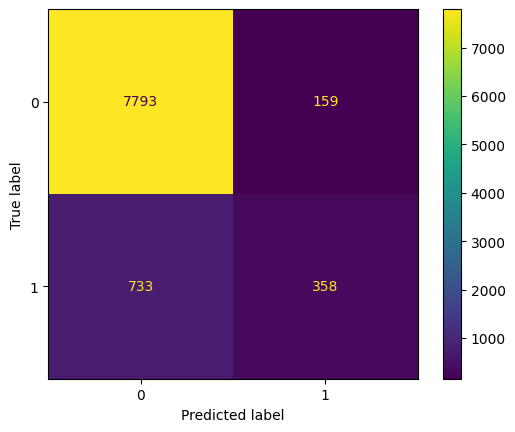

In [34]:
forest_cm = confusion_matrix(y_test, forest_y_pred)
forest_cmd = ConfusionMatrixDisplay(forest_cm)
forest_cmd.plot()

forest_accuracy = accuracy_score(y_test, forest_y_pred)
forest_accuracy

In [54]:
print(classification_report(y_test, forest_y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      7952
         1.0       0.69      0.33      0.45      1091

    accuracy                           0.90      9043
   macro avg       0.80      0.65      0.70      9043
weighted avg       0.89      0.90      0.89      9043



It's a 3% improvement in accuracy from our single decision tree, which isn't nothing.

Now let's see if an ADABoost model can do any better.

The basic premise of ADABoost is that it builds several decision trees like a random forest, but each tree that is built learns from other trees that have miscategorized a target label. 

More detailed explanations of the mechanics of ADABoost can be found here. https://www.mygreatlearning.com/blog/adaboost-algorithm/#:~:text=AdaBoost%20algorithm%2C%20short%20for%20Adaptive,assigned%20to%20incorrectly%20classified%20instances.

In [35]:
#ada boost classifier
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

ada_scores = cross_val_score(ada, X_train, y_train, cv=5, scoring='accuracy')

ada_scores


array([0.89922588, 0.90060824, 0.89894941, 0.89948846, 0.90239182])

Our ADABoost performs roughly the same as the random forest did. Hopefully some tuning gets us close to the mid 90s. 

However, we've noticed that tuning lots of hyperparameters doesn't really help us, so we'll focus on the two main ones: learning rate and n_estimators. 

n_estimators measures the number of weak learners we want to use in our dataset. The higher this number goes, the more time we have to spend modeling, so let's try to simplify our models to see if we get better results, since tree-based classifiers tend to naturally overfit.

Learning rate shrinks the input of each individual tree it crates downstream. Think: how much does the second tree have to pay attention to the first one for notes?

In [36]:
ada_hyperperams = {
    "n_estimators" : [1,2,5,10],
    "learning_rate" : [1,2,3,4,5], 
}

ada_grid = GridSearchCV(ada, ada_hyperperams, cv=5, scoring='accuracy')

In [37]:
ada_grid.fit(X_train, y_train)

ada_grid.best_params_

{'learning_rate': 1, 'n_estimators': 10}

Once again we have our best hyperparameters, but we must implement them to really see what's going.

When manually checking performance, only tuning the learning rate had a noticeable effect on performance.

In [38]:
ada_tuned = AdaBoostClassifier(learning_rate = 1, random_state=42)

ada_tuned.fit(X_train, y_train)

ada_tuned_scores = cross_val_score(ada_tuned, X_train, y_train, cv=5, scoring='accuracy')

ada_tuned_scores

array([0.89922588, 0.90060824, 0.89894941, 0.89948846, 0.90239182])

In [39]:
ada_tuned_scores.mean()

0.9001327586472485

Our mean accuracy is almost identical to our forest, but it all comes down to the test data.

0.8983744332632976

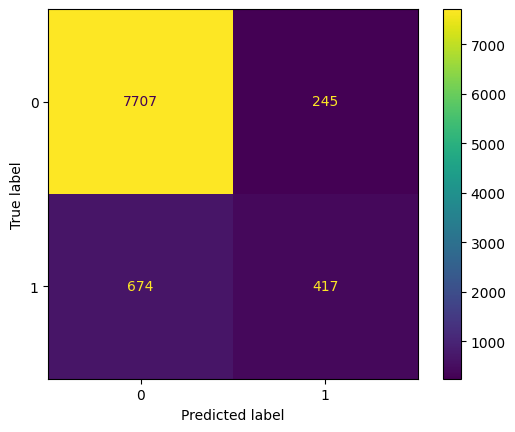

In [40]:
y_pred_ada = ada_tuned.predict(X_test)

cm_ada = confusion_matrix(y_test, y_pred_ada)
cmd_ada = ConfusionMatrixDisplay(cm_ada)
cmd_ada.plot()

ada_accuracy = accuracy_score(y_test, y_pred_ada)
ada_accuracy

In [55]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      7952
         1.0       0.63      0.38      0.48      1091

    accuracy                           0.90      9043
   macro avg       0.77      0.68      0.71      9043
weighted avg       0.88      0.90      0.89      9043



Our ADABoost scored 89.8% on test data, which is lower than our random forest. So, we will ask the most accurate model, our tuned random forest, for the feature importances so that we can create business recommendations.

In [41]:
tuned_forest.feature_importances_

array([0.07498815, 0.00162478, 0.07666856, 0.02778363, 0.00991188,
       0.06602417, 0.34009138, 0.03482941, 0.03558511, 0.02341281,
       0.00698049, 0.00812432, 0.00320451, 0.00261707, 0.00748774,
       0.00452814, 0.00346114, 0.00551161, 0.00385191, 0.00798348,
       0.00352052, 0.00093278, 0.00516007, 0.00884406, 0.00768589,
       0.0059312 , 0.00863961, 0.00882196, 0.00385666, 0.01707573,
       0.00425527, 0.02780125, 0.01197135, 0.00981614, 0.00231339,
       0.00741124, 0.00496296, 0.00966438, 0.00996736, 0.01189558,
       0.01323674, 0.00832145, 0.01079772, 0.00620854, 0.00640047,
       0.00935566, 0.03048172])

In [42]:
important_features = pd.DataFrame()
scores = tuned_forest.feature_importances_
features = X.columns
important_features['scores'] = pd.Series(scores)
important_features['features'] = pd.Series(features)
important_features.sort_values(by='scores', ascending=False)

,scores,features
6,0.340091,last contact duration in seconds
2,0.076669,account balance
0,0.074988,age
5,0.066024,last contact day
8,0.035585,days since last contact
7,0.034829,number of contacts
46,0.030482,outcome of previous marketing campaign_success
31,0.027801,contact type_unknown
3,0.027784,housing loan
9,0.023413,number of contacts before current campaign


Our top 5 are call duration, account balance, age, last contacted ay of the month, and number of contacts. 

Below we'll look through the data for people who have subscribed and look for good starting points for these features as targets to aim for.

In [43]:
important_features.to_csv('important_features.csv')

In [44]:
#find correlation between 'last contact duration' and 'subscribed to term deposit'
df['subscribed to term deposit'].corr(df['last contact duration in seconds'])

0.3945210158945622

In [45]:
#find correlation between 'age' and 'subscribed to term deposit'
df['subscribed to term deposit'].corr(df['age'])

0.025155017088380926

In [46]:
#find correlation between account balance and subscribed to term deposit
df['subscribed to term deposit'].corr(df['account balance'])

0.052838410288182924

In [47]:
df_sub = df_post_model[df_post_model['subscribed to term deposit'] == 1.0]

df_sub

,age,job,marital status,education level,credit in default,account balance,housing loan,personal loan,contact type,last contact day,last contact month,last contact duration in seconds,number of contacts,days since last contact,number of contacts before current campaign,outcome of previous marketing campaign,subscribed to term deposit
83,59.0,admin.,married,secondary,0.0,2343.0,1.0,0.0,unknown,5.0,may,1042.0,1.0,-1.0,0.0,other,1.0
86,56.0,admin.,married,secondary,0.0,45.0,0.0,0.0,unknown,5.0,may,1467.0,1.0,-1.0,0.0,other,1.0
87,41.0,technician,married,secondary,0.0,1270.0,1.0,0.0,unknown,5.0,may,1389.0,1.0,-1.0,0.0,other,1.0
129,55.0,services,married,secondary,0.0,2476.0,1.0,0.0,unknown,5.0,may,579.0,1.0,-1.0,0.0,other,1.0
168,54.0,admin.,married,tertiary,0.0,184.0,0.0,0.0,unknown,5.0,may,673.0,2.0,-1.0,0.0,other,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45204,73.0,retired,married,secondary,0.0,2850.0,0.0,0.0,cellular,17.0,nov,300.0,1.0,40.0,8.0,failure,1.0
45205,25.0,technician,single,secondary,0.0,505.0,0.0,1.0,cellular,17.0,nov,386.0,2.0,-1.0,0.0,other,1.0
45206,51.0,technician,married,tertiary,0.0,825.0,0.0,0.0,cellular,17.0,nov,977.0,3.0,-1.0,0.0,other,1.0
45207,71.0,retired,divorced,primary,0.0,1729.0,0.0,0.0,cellular,17.0,nov,456.0,2.0,-1.0,0.0,other,1.0


In [48]:
df_sub['last contact duration in seconds'].median()

426.0

In [49]:
df_sub['age'].median()

38.0

In [50]:
df_sub['account balance'].mean()

1804.2679145396105

Overall, I can come up with 4 concrete recommendations from the data:

1. Take your time on phone calls. It seems to be the same phenomenon as websites and phsyical stores: the more time someone spends interfacing with the product or service, the more likely they are to buy it. So sales reps can take their time, talk to people like normal humans, and have scripts that last at least 426 seconds, or just over 7 minutes.

undefined.  Target customers with an account balance of at least $1800 to start

undefined. Target customers who are at least 38 years old

undefined. Call people more frequently as follow-ups

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=06e3dfc8-644b-4557-8360-2880e77950d3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>